In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
tf.enable_eager_execution()

## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [6]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [21]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [26]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [11]:
test = PiecewiseQuadratic(6,3,5)

In [20]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [27]:
tf.disable_eager_execution()

In [2]:
bijectors = []

for i in range(2):
    bijectors.append(PiecewiseLinear(2,1,5,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
_________________________________________________________________
reshape (Reshape)            (None, 1, 5)              0         
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
The TensorFlow Distributions library has 

In [3]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [4]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

Tensor("PiecewiseLinear/forward/Pad:0", shape=(1000, 1, 6), dtype=float32)
Tensor("PiecewiseLinear_1/forward/Pad:0", shape=(1000, 1, 6), dtype=float32)


In [6]:
sess = tf.InteractiveSession()

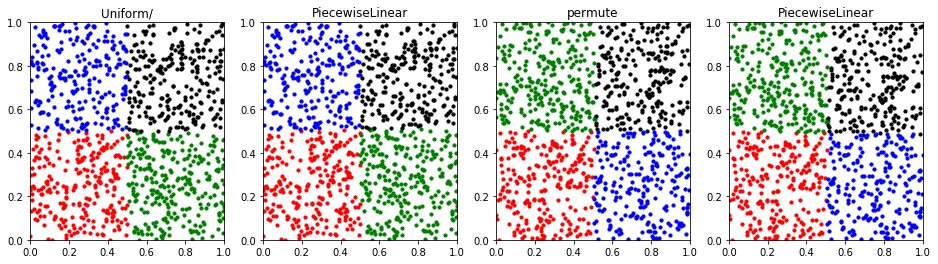

In [7]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [164]:
def dsigma(x):
    return tf.where(np.logical_and(x[:,0] < np.ones_like(x[:,0])*0.9,x[:,1] < np.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), np.zeros_like(x[:,0]))

In [165]:
samples = np.array(np.random.rand(1000,2),dtype=NP_DTYPE)
x = bijector.inverse(samples)
X = bijector.pdf(x)
dsig = dsigma(x)
print(tf.reduce_prod(X,axis=-1), '\n', dsig)

tf.Tensor(
[0.50868315 0.19002455 0.49499726 0.86940897 0.21817303 1.018231
 0.71203685 0.9141156  0.9908575  0.40989432 0.17891505 0.47341225
 0.33268487 0.7077338  0.41432306 0.4293134  0.14075835 0.51145977
 0.6572349  0.3535929  0.22096866 0.38204247 0.09866763 0.8893694
 0.5236993  0.35003617 1.0414289  0.72864205 0.08749794 0.6260667
 0.36858416 0.291443   0.32017958 0.12808877 0.2878014  0.7098302
 0.42491442 0.48026654 0.9829343  0.2582002  0.40324524 0.4209217
 0.16988598 0.7116816  0.6376277  0.4961611  0.47989216 0.7791909
 0.10361455 0.4311784  0.11911344 0.21295862 0.26741606 0.27136043
 0.3005633  0.4877625  0.18803735 0.90323603 0.9123633  0.84592366
 0.2194299  0.6663656  0.7441445  0.71527034 0.25496164 0.14595959
 0.60809606 1.1275607  0.41164804 0.44395354 0.49920005 0.01852336
 0.32914418 0.54958206 0.39660683 0.92276335 0.81712514 0.68254906
 0.5952455  0.01790674 0.6290666  0.43368956 0.78958786 0.9950074
 0.93268883 0.33662558 0.07431995 0.19993299 0.35225496 0.6

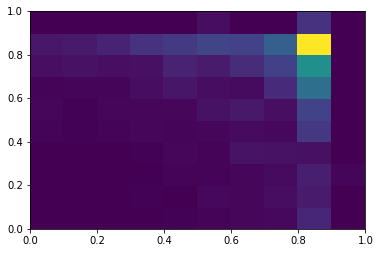

In [130]:
plt.hist2d(x[:,0],x[:,1],weights=dsig)
plt.show()

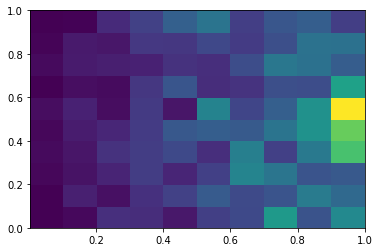

In [166]:
plt.hist2d(x[:,0],x[:,1],weights=tf.reduce_prod(X,axis=-1)*tf.exp(bijector.forward_log_det_jacobian(x,event_ndims=1)))
plt.show()

In [167]:
loss = -tf.reduce_mean(dsig*tf.log(tf.reduce_prod(X,axis=-1)))
print(loss)

tf.Tensor(2.2859654, shape=(), dtype=float32)


In [168]:
def loss_fn(x):
    x = bijector.inverse(x)
    q = tf.reduce_prod(bijector.pdf(x),axis=-1)
    p = dsigma(x)
    return -tf.reduce_mean(p*(tf.log(q)+bijector.forward_log_det_jacobian(x,event_ndims=1)))

In [169]:
def grad(x):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x)
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [170]:
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.Variable(0)

loss_value, grads = grad(samples)

print(loss_value, grads)


tf.Tensor(2.3752754, shape=(), dtype=float32) [None, None, None, None, None, None]
